In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
import os, sys
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, plot_roc_curve,plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy

In [3]:
!git clone https://github.com/avidutta20/challenge_may21

Cloning into 'challenge_may21'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 55 (delta 21), reused 26 (delta 6), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [4]:
os.chdir('/content/challenge_may21/')

In [99]:
def load_data():
    pass
df = pd.read_csv('dataset/av_jobathon_may21_train.csv')

# creating a list of all trainable features name
feature_list = df.columns[1:10]
target = df.columns[10]  # 'Is_Lead' column name

# splitting into train & test
x_train, x_test, y_train, y_test = train_test_split(df[feature_list], df[target], test_size=0.25, random_state=25)


In [88]:
def get_raw_train_data(with_labels = False):
  # splitting into train & test
  x_train, x_test, y_train, y_test = train_test_split(df[feature_list], df[target], test_size=0.25, random_state=25)
    
  if with_labels:
    x_train['Is_Lead'] = y_train

  return x_train

In [100]:
# creating a x_train_complete x_train_df copy
x_train_df = x_train.copy()
x_train_df['Is_Lead'] = y_train

# creating a x_train processing_experimenting copy
x_train_raw = x_train_df.copy()

#Data Processing

In [101]:
def checking_dataset_balance(df,feature_name, target):
  
  class_labels = df[target].unique()
  total_rows = df[target].count()
  class_dict={}
  for label in class_labels:
    class_dict[label] = {'value': df[target].loc[df[target]==label].count()}
    class_dict[label]['perc'] = (df[target].loc[df[target]==label].count())/total_rows
  return class_dict

# checking dataset imbalance
checking_dataset_balance(df,feature_list,target)

# dataset is not imbalanced.

{0: {'perc': 0.7627917387323228, 'value': 187437},
 1: {'perc': 0.23720826126767727, 'value': 58288}}

## Processing Catagorical Values

In [233]:
def execute_process(dframe, colname,func,arg1):
    colname_new = colname + '_proc'
    dframe[colname_new] = dframe[colname].apply(lambda x: func(x,arg1))
    return dframe
def extract_process(value,index):
    value = int(value[index:])
    return value

def replace_values(value, value_dic):
    # replaces any value in the dframe colname with given dict
    return value_dic[value]

def default_value():
    return 0

def one_hot(dframe, colname):
  onehotencoder = OneHotEncoder()
  #reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
  X = onehotencoder.fit_transform(dframe[colname].values.reshape(-1,1)).toarray()
  # creating a dataframe 
  dfOneHotx = pd.DataFrame(X, columns = [colname+"_"+str(int(i)) for i in range(len(dframe[colname].unique()))])
  # adding index to the dataframe as dframe for joining
  dfOneHotx.set_index(dframe.index, inplace=True)
  # concatinating the two
  df2 = pd.concat([dframe, dfOneHotx], axis = 1)
  
  return df2

In [234]:
def process(dframe, default_func = default_value):
  gender_dic = is_active_dic = occupation_dic = defaultdict(default_value)


  gender_dic = is_active_dic = occupation_dic = defaultdict(default_value)
  
  gender_dic = {'Male': 0,
                  'Female': 1}
  is_active_dic = {'Yes': 1,
                  'No': 0}

  occupation_dic = {'Self_Employed': 1,
                      'Other': 2,
                      'Salaried': 3,
                      'Entrepreneur': 4}

  execute_process(dframe,'Region_Code', extract_process, 2)
  print('Region Code Processed Successfully')

  execute_process(dframe,'Channel_Code', extract_process, 1)
  print('Channel Code Processed Successfully')
  dframe = one_hot(dframe, 'Channel_Code_proc')

  dframe = execute_process(dframe,'Gender', replace_values, gender_dic)
  print('Gender Processed Successfully')
  dframe = one_hot(dframe, 'Gender_proc')

  execute_process(dframe,'Occupation', replace_values, occupation_dic)
  print('Occupation Processed Successfully')
  dframe = one_hot(dframe, 'Occupation_proc')

  execute_process(dframe,'Is_Active',replace_values, is_active_dic)
  print('Is Active Processed Successfully')
  dframe = one_hot(dframe, 'Is_Active_proc')

  dframe['Credit_Product'] = dframe['Credit_Product'].fillna('No')
  execute_process(dframe,'Credit_Product',replace_values, is_active_dic)
  dframe = one_hot(dframe, 'Credit_Product_proc')
  return dframe

## Cheking SkewNess

In [10]:
# # checking skewness
# scipy.stats.skew(x_train_df['Avg_Account_Balance'])

2.9757408570525747

In [235]:
x_train_df = get_raw_train_data(with_labels=True)

In [236]:
# processing x_train_df
x_train_df = process(x_train_df)

Region Code Processed Successfully
Channel Code Processed Successfully
Gender Processed Successfully
Occupation Processed Successfully
Is Active Processed Successfully


In [237]:
x_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184293 entries, 188708 to 29828
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 184293 non-null  object 
 1   Age                    184293 non-null  int64  
 2   Region_Code            184293 non-null  object 
 3   Occupation             184293 non-null  object 
 4   Channel_Code           184293 non-null  object 
 5   Vintage                184293 non-null  int64  
 6   Credit_Product         184293 non-null  object 
 7   Avg_Account_Balance    184293 non-null  int64  
 8   Is_Active              184293 non-null  object 
 9   Is_Lead                184293 non-null  int64  
 10  Region_Code_proc       184293 non-null  int64  
 11  Channel_Code_proc      184293 non-null  int64  
 12  Channel_Code_proc_0    184293 non-null  float64
 13  Channel_Code_proc_1    184293 non-null  float64
 14  Channel_Code_proc_2    184293 no

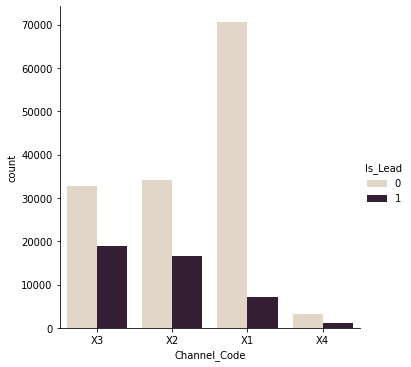

In [14]:
sns.catplot(x='Channel_Code', hue = 'Is_Lead', kind="count", palette="ch:.25", data=x_train_df)

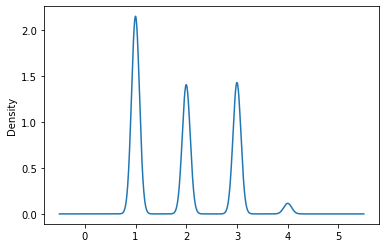

In [15]:
x_train_df['Channel_Code_proc'].plot.kde()

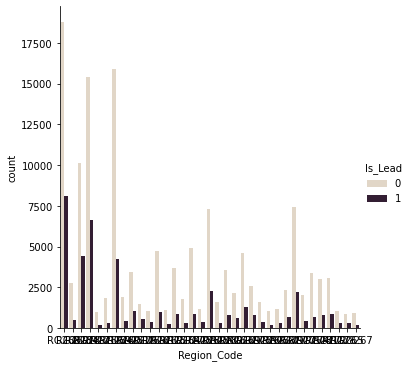

In [16]:
sns.catplot(x='Region_Code', hue = 'Is_Lead', kind="count", palette="ch:.25", data=x_train_df)

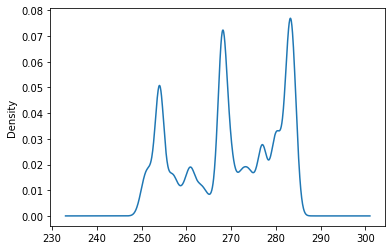

In [17]:
x_train_df['Region_Code_proc'].plot.kde()

In [ ]:
# Checking Integral datas
# columns are:Age, Vintage, Account_Balance

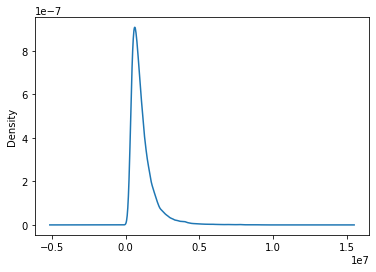

In [18]:
x_train_df['Avg_Account_Balance'].plot.kde()

In [19]:
# the graph shows the average balance is highly right skewed.
# calculating skewness
skew_ac_bal = scipy.stats.skew(x_train_df['Avg_Account_Balance'])
# a +ve high value as expected
skew_ac_bal

2.9757408570525747

## log transform

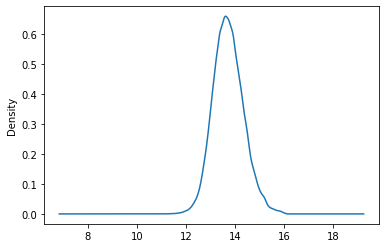

In [20]:
# let's log transform it reduce to reduce it's skewness
#log_transforming
def log_transform(x):
  result = 0.0
  if x!=0:
    result = np.log(x)
  else:
    result = np.log(0.00001)
  return result

x_train_df['Avg_Account_Balance_log'] = x_train_df['Avg_Account_Balance'].apply(lambda x: log_transform(x))
x_train_df['Avg_Account_Balance_log'].plot.kde()

In [21]:
# checking new skew
skew_ac_bal_log = scipy.stats.skew(x_train_df['Avg_Account_Balance_log'])
print(f'Skew after applying log_transform to "Avg_Account_Balance_log is {skew_ac_bal_log}"')
# which is less than +0.5 showing a good normal curve as we wanted

Skew after applying log_transform to "Avg_Account_Balance_log is 0.23654555482098255"


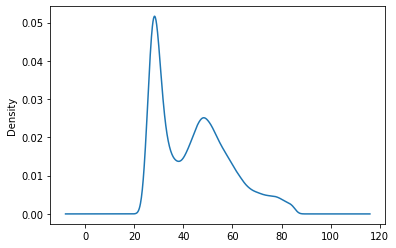

In [22]:
# Age
x_train_df['Age'].plot.kde()

In [23]:
# the graph shows the age is also not normal.
# based on inspecting we will break the age into three groups based on the local minimas in graph
# 0-20, 20-40,40-60, 60 and up
def bin_age(x):
  # catagories = ['0-20','20-40','40-60','60+']
  cat = ''
  
  if x>20 and x<=40:
    cat = '20-40'
  elif x>40 and x<=60:
    cat = '40-60'
  elif x>60 :
    cat = '60+'
  else :
    cat = '0-20'
  return cat



In [24]:
x_train_df['Age_Binned'] = x_train_df['Age'].apply(lambda x: bin_age(x))
x_train_df

Gender  Age  ... Avg_Account_Balance_log Age_Binned
188708    Male   44  ...               13.205711      40-60
17007   Female   50  ...               13.701104      40-60
109929    Male   77  ...               13.966871        60+
81455     Male   74  ...               14.357853        60+
77866   Female   25  ...               14.214079      20-40
...        ...  ...  ...                     ...        ...
130365  Female   68  ...               14.528371        60+
92303   Female   34  ...               13.679998      20-40
6618      Male   28  ...               13.986131      20-40
90430   Female   50  ...               14.315680      40-60
29828   Female   31  ...               14.085102      20-40

[184293 rows x 18 columns]

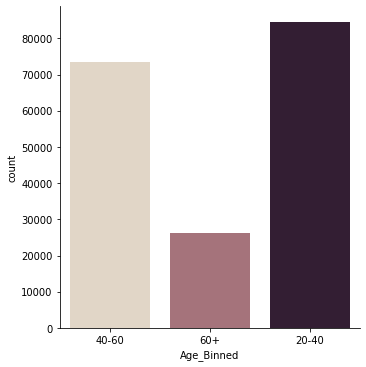

In [25]:
sns.catplot(x='Age_Binned', kind="count", palette="ch:.25", data=x_train_df)

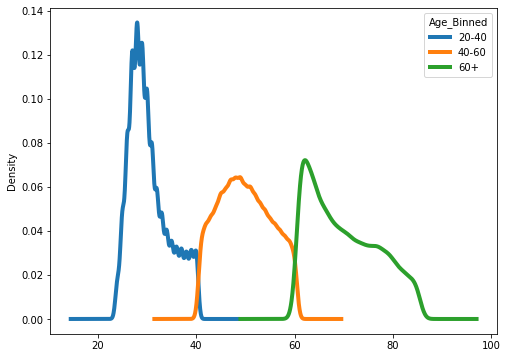

In [26]:
# Converting to wide dataframe
data_wide = x_train_df.pivot(columns = 'Age_Binned',
                     values = 'Age')
  
# plotting multiple density plot
data_wide.plot.kde(figsize = (8, 6),
                   linewidth = 4)

## age next transform

In [ ]:
# We see that the graph are normal in their group

In [27]:
# x_train['Age_log'] = x_train['Age'].apply(lambda x: log_transform(np.exp(x)))
# x_train['Age_Binned_log'] = x_train['Age_log'].apply(lambda x: bin_age(x))
# using box_cox transform
# transform training data & save lambda value
x_train_df['Age_box'], fitted_lambda = scipy.stats.boxcox(x_train_df['Age'])

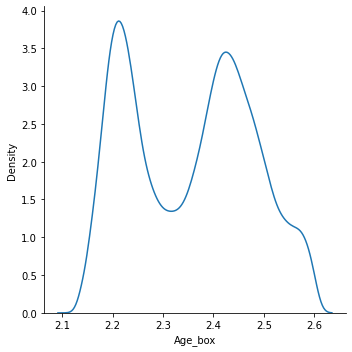

In [28]:
sns.displot(x='Age_box',kind='kde',data=x_train_df)

In [44]:
# # Converting to wide dataframe
# data_wide = x_train_df.pivot(columns = 'Age_Binned_log',
#                      values = 'Age_box')
  
# # plotting multiple density plot
# data_wide.plot.kde(figsize = (8, 6),
#                    linewidth = 4)

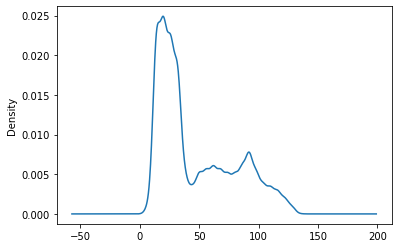

In [29]:
# Vintage
x_train_df['Vintage'].plot.kde()

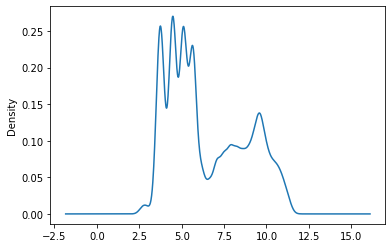

In [30]:
x_train_df['Vintage_sqrt'] = x_train_df['Vintage'].apply(lambda x: np.sqrt(x))
x_train_df['Vintage_sqrt'].plot.kde()

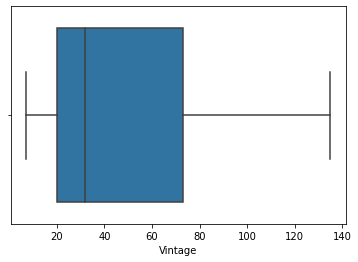

In [31]:
sns.boxplot(x='Vintage',data=x_train_df)

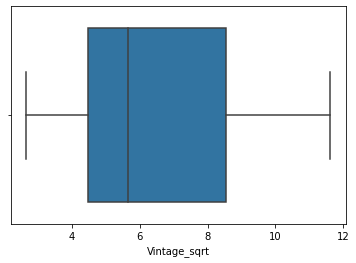

In [32]:
sns.boxplot(x='Vintage_sqrt',data=x_train_df)

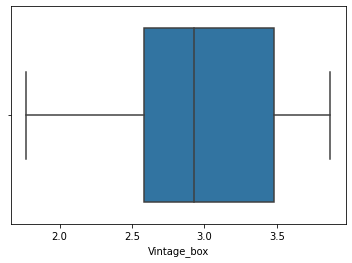

In [33]:
x_train_df['Vintage_box'], fitted_lambda = scipy.stats.boxcox(x_train_df['Vintage'])
sns.boxplot(x='Vintage_box',data=x_train_df)

In [34]:
x_train['Vintage']

188708    87
17007     69
109929    81
81455     14
77866     21
          ..
130365    93
92303     20
6618      26
90430     55
29828     25
Name: Vintage, Length: 184293, dtype: int64

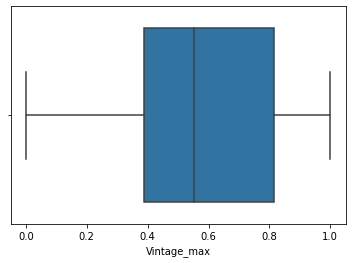

In [35]:
normalize = MinMaxScaler()
array = np.asanyarray(x_train_df['Vintage_box'])
array = array.reshape(-1,1)

array_norm = normalize.fit_transform(array)

std_scaler = StandardScaler()
array_std = std_scaler.fit_transform(array_norm)

# applying both the functions
x_train_df['Vintage_max'] = array_norm
# x_train['Vintage_std'] = array_std

sns.boxplot(x='Vintage_max',data=x_train_df)


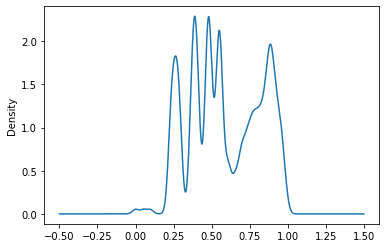

In [36]:
x_train_df['Vintage_max'].plot.kde()

In [38]:
# reshaping the column to apply minmax scaler
array = np.asanyarray(x_train_df['Age_Binned'])
array = array.reshape(-1,1)

# normalizing using minmax scaler
enc = OneHotEncoder()
array_enc = enc.fit_transform(array)

x_train_df

Gender  Age Region_Code  ... Vintage_sqrt Vintage_box  Vintage_max
188708    Male   44       RG268  ...     9.327379    3.595466     0.869727
17007   Female   50       RG252  ...     8.306624    3.445993     0.798635
109929    Male   77       RG284  ...     9.000000    3.549759     0.847988
81455     Male   74       RG283  ...     3.741657    2.316994     0.261663
77866   Female   25       RG283  ...     4.582576    2.621427     0.406457
...        ...  ...         ...  ...          ...         ...          ...
130365  Female   68       RG254  ...     9.643651    3.637827     0.889875
92303   Female   34       RG284  ...     4.472136    2.585449     0.389346
6618      Male   28       RG253  ...     5.099020    2.776846     0.480377
90430   Female   50       RG284  ...     7.416198    3.296341     0.727458
29828   Female   31       RG255  ...     5.000000    2.748555     0.466921

[184293 rows x 22 columns]

## tranform function

In [243]:
def transform(dframe):
  # apply the transformations in dframe
  
  # ---------------------------- Functions -----------------------------------
  
  def bin_age(x):
    # catagories = ['0-20','20-40','40-60','60+']
    cat = ''
    
    if x>20 and x<=40:
      cat = '20-40'
    elif x>40 and x<=60:
      cat = '40-60'
    elif x>60 :
      cat = '60+'
    else :
      cat = '0-20'
    return cat

  def log_transform(x):
    # transforms x to log
    result = 0.0
    if x!=0:
      result = np.log(x)
    else:
      result = np.log(0.00001)
    return result

  # ----------------------------------------------------------------------------
  
  # transforming age
  # creating age bins
  dframe['Age_Binned'] = dframe['Age'].apply(lambda x: bin_age(x))
  dframe = one_hot(dframe, 'Age_Binned')
  # applying boxcox transformation
  dframe['Age_box'], fitted_lambda = scipy.stats.boxcox(dframe['Age'])

  # transforming balance
  dframe['Avg_Account_Balance_log'] = dframe['Avg_Account_Balance'].apply(lambda x: log_transform(x))

  # transforming vintage
  # applying boxcox transfrom
  dframe['Vintage_box'], fitted_lambda = scipy.stats.boxcox(dframe['Vintage'])
  # reshaping the column to apply minmax scaler
  array = np.asanyarray(dframe['Vintage_box'])
  array = array.reshape(-1,1)
  
  # normalizing using minmax scaler
  normalize = MinMaxScaler()
  array_norm = normalize.fit_transform(array)

  # applying standard_scaler
  std_scaler = StandardScaler()
  array_std = std_scaler.fit_transform(array_norm)

  # applying both the functions
  dframe['Vintage_max'] = array_norm

  return dframe

In [251]:
def get_features(dframe):
  feature_list_to_use = ['Channel_Code_proc_0','Channel_Code_proc_1', 'Channel_Code_proc_2', 'Channel_Code_proc_3',
  'Gender_proc_0', 'Gender_proc_1',
  'Occupation_proc_0', 'Occupation_proc_1', 'Occupation_proc_2','Occupation_proc_3',
  'Is_Active_proc_0', 'Is_Active_proc_1', 
  'Credit_Product_proc_0', 'Credit_Product_proc_1',
  'Age_Binned_0', 'Age_Binned_1','Age_Binned_2', 
  'Age_box', 'Avg_Account_Balance_log', 'Vintage_max']
  return dframe[feature_list_to_use]

In [53]:
x_train_df.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Is_Lead',
       'Region_Code_proc', 'Channel_Code_proc', 'Gender_proc',
       'Occupation_proc', 'Is_Active_proc', 'Credit_Product_proc',
       'Avg_Account_Balance_log', 'Age_Binned', 'Age_box', 'Vintage_sqrt',
       'Vintage_box', 'Vintage_max'],
      dtype='object')

In [252]:
x_train = get_raw_train_data()

In [253]:
x_train

Gender  Age Region_Code  ... Credit_Product Avg_Account_Balance  Is_Active
188708    Male   44       RG268  ...             No              543460         No
17007   Female   50       RG252  ...             No              891895        Yes
109929    Male   77       RG284  ...             No             1163416         No
81455     Male   74       RG283  ...             No             1720031         No
77866   Female   25       RG283  ...             No             1489690        Yes
...        ...  ...         ...  ...            ...                 ...        ...
130365  Female   68       RG254  ...             No             2039817        Yes
92303   Female   34       RG284  ...             No              873268        Yes
6618      Male   28       RG253  ...             No             1186040        Yes
90430   Female   50       RG284  ...            NaN             1649000        Yes
29828   Female   31       RG255  ...             No             1309430         No

[184293 rows x 9 columns]

In [267]:
print(x_train.__doc__)


    Two-dimensional, size-mutable, potentially heterogeneous tabular data.

    Data structure also contains labeled axes (rows and columns).
    Arithmetic operations align on both row and column labels. Can be
    thought of as a dict-like container for Series objects. The primary
    pandas data structure.

    Parameters
    ----------
    data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
        Dict can contain Series, arrays, constants, or list-like objects.

        .. versionchanged:: 0.23.0
           If data is a dict, column order follows insertion-order for
           Python 3.6 and later.

        .. versionchanged:: 0.25.0
           If data is a list of dicts, column order follows insertion-order
           for Python 3.6 and later.

    index : Index or array-like
        Index to use for resulting frame. Will default to RangeIndex if
        no indexing information part of input data and no index provided.
    columns : Index or array-like
    

In [254]:
def process_all(dframe):
  x_train = process(x_train)
  x_train = transform(x_train)
  print('x_train transformed successfully')
  x_train = get_features(x_train)
  print('x_train features engineered')
  return dframe


Region Code Processed Successfully
Channel Code Processed Successfully
Gender Processed Successfully
Occupation Processed Successfully
Is Active Processed Successfully
x_train transformed successfully
x_train features engineered


In [256]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184293 entries, 188708 to 29828
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Channel_Code_proc_0      184293 non-null  float64
 1   Channel_Code_proc_1      184293 non-null  float64
 2   Channel_Code_proc_2      184293 non-null  float64
 3   Channel_Code_proc_3      184293 non-null  float64
 4   Gender_proc_0            184293 non-null  float64
 5   Gender_proc_1            184293 non-null  float64
 6   Occupation_proc_0        184293 non-null  float64
 7   Occupation_proc_1        184293 non-null  float64
 8   Occupation_proc_2        184293 non-null  float64
 9   Occupation_proc_3        184293 non-null  float64
 10  Is_Active_proc_0         184293 non-null  float64
 11  Is_Active_proc_1         184293 non-null  float64
 12  Credit_Product_proc_0    184293 non-null  float64
 13  Credit_Product_proc_1    184293 non-null  float64
 14  

In [248]:
x_train.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Region_Code_proc', 'Channel_Code_proc', 'Channel_Code_proc_0',
       'Channel_Code_proc_1', 'Channel_Code_proc_2', 'Channel_Code_proc_3',
       'Gender_proc', 'Gender_proc_0', 'Gender_proc_1', 'Occupation_proc',
       'Occupation_proc_0', 'Occupation_proc_1', 'Occupation_proc_2',
       'Occupation_proc_3', 'Is_Active_proc', 'Is_Active_proc_0',
       'Is_Active_proc_1', 'Credit_Product_proc', 'Credit_Product_proc_0',
       'Credit_Product_proc_1', 'Age_Binned', 'Age_Binned_0', 'Age_Binned_1',
       'Age_Binned_2', 'Age_box', 'Avg_Account_Balance_log', 'Vintage_box',
       'Vintage_max'],
      dtype='object')

In [249]:
feature_list_to_use = ['Channel_Code_proc_0','Channel_Code_proc_1', 'Channel_Code_proc_2', 'Channel_Code_proc_3',
 'Gender_proc_0', 'Gender_proc_1',
 'Occupation_proc_0', 'Occupation_proc_1', 'Occupation_proc_2','Occupation_proc_3',
 'Is_Active_proc_0', 'Is_Active_proc_1', 
 'Credit_Product_proc_0', 'Credit_Product_proc_1',
 'Age_Binned_0', 'Age_Binned_1','Age_Binned_2', 
 'Age_box', 'Avg_Account_Balance_log', 'Vintage_max']

In [ ]:
x_train = x_train['Region_Code_proc', 'Channel_Code_proc', 'Gender_proc',
       'Occupation_proc', 'Is_Active_proc', 'Credit_Product_proc',
       'Avg_Account_Balance_log', 'Age_Binned', 'Age_box', 'Vintage_max']

## jump here

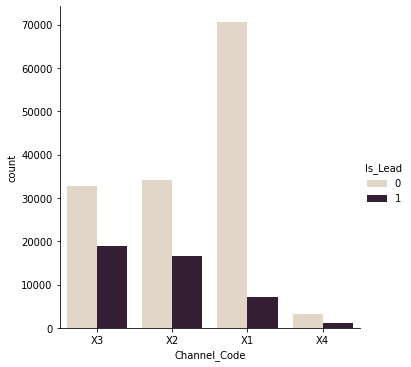

In [24]:
# sns.catplot(x="Channel_Code", kind="count", hue = "Is_Lead", palette="ch:.25", data=x_train_visual)
# # df['Channel_Code'].plot.kde()

# #jump Here

In [99]:
x_train.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage_max', 'Credit_Product', 'Is_Active',
       'Avg_Account_Balance_log'],
      dtype='object')

In [92]:
# # processing x_train
# x_train = process(x_train)
# print('X_Train processed successfully!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Region Code Processed Successfully
Channel Code Processed Successfully
Gender Processed Successfully
Occupation Processed Successfully
Is Active Processed Successfully
X_Train processed successfully!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [97]:
# processing df matrix
# df_processed = process(df)

In [98]:
# corr_mat_process = df_processed.corr(method = 'kendall')
# corr_mat_process

In [96]:
# corr_mat = x_train.corr()
# # corr_mat

In [95]:
# type(corr_mat)

# Model Fitting

In [257]:
# %% Implementing Random Forests

clf_rforest = RandomForestClassifier(random_state= 10, max_features="log2", oob_score= True)
clf_rforest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
x_train

Gender  Age  ...  Is_Active  Avg_Account_Balance_log
188708       0   44  ...          0                13.205711
17007        1   50  ...          1                13.701104
109929       0   77  ...          0                13.966871
81455        0   74  ...          0                14.357853
77866        1   25  ...          1                14.214079
...        ...  ...  ...        ...                      ...
130365       1   68  ...          1                14.528371
92303        1   34  ...          1                13.679998
6618         0   28  ...          1                13.986131
90430        1   50  ...          1                14.315680
29828        1   31  ...          0                14.085102

[184293 rows x 9 columns]

In [264]:
# %%
# getting important features
feature_list = x_train.columns
imp_feature = {}
for feat_name, weight in zip(feature_list, clf_rforest.feature_importances_):
    imp_feature[feat_name] = weight


for key in imp_feature:
    value = round(imp_feature[key],3)*100
    print(f'{key} : {value} %')

Channel_Code_proc_0 : 2.9000000000000004 %
Channel_Code_proc_1 : 0.7000000000000001 %
Channel_Code_proc_2 : 0.8999999999999999 %
Channel_Code_proc_3 : 0.1 %
Gender_proc_0 : 0.4 %
Gender_proc_1 : 0.4 %
Occupation_proc_0 : 0.8 %
Occupation_proc_1 : 0.8999999999999999 %
Occupation_proc_2 : 2.8000000000000003 %
Occupation_proc_3 : 0.5 %
Is_Active_proc_0 : 0.7000000000000001 %
Is_Active_proc_1 : 0.7000000000000001 %
Credit_Product_proc_0 : 0.6 %
Credit_Product_proc_1 : 0.5 %
Age_Binned_0 : 1.3 %
Age_Binned_1 : 1.0 %
Age_Binned_2 : 0.3 %
Age_box : 18.0 %
Avg_Account_Balance_log : 44.4 %
Vintage_max : 22.3 %


In [ ]:
# processing x_test
x_test = process(dframe= x_test)


Region Code Processed Successfully
Channel Code Processed Successfully
Gender Processed Successfully
Occupation Processed Successfully
Is Active Processed Successfully


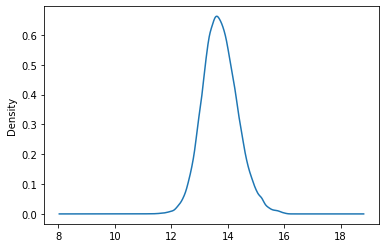

In [ ]:
x_test['Avg_Account_Balance_log'] = x_test['Avg_Account_Balance'].apply(lambda x: log_transform(x))
x_test['Avg_Account_Balance_log'].plot.kde()

In [ ]:
x_test.pop('Avg_Account_Balance')

171739    1237838
98848      678162
184607     343593
61725      960701
48107     2209273
           ...   
236899    1914950
65610     1052300
42881      387123
199081     630387
104851     336206
Name: Avg_Account_Balance, Length: 61432, dtype: int64

In [ ]:
x_test

Gender  Age  ...  Is_Active  Avg_Account_Balance_log
171739       1   30  ...          0                14.028877
98848        0   29  ...          1                13.427141
184607       1   29  ...          0                12.747213
61725        0   28  ...          1                13.775419
48107        0   57  ...          0                14.608174
...        ...  ...  ...        ...                      ...
236899       0   65  ...          1                14.465202
65610        1   28  ...          0                13.866489
42881        1   27  ...          0                12.866498
199081       0   43  ...          1                13.354089
104851       0   38  ...          1                12.725479

[61432 rows x 9 columns]

In [ ]:
y_hat_rforest = clf_rforest.predict(x_test)
y_hat_rf_proba = clf_rforest.predict_proba(x_test)

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_hat_rforest)
print(accuracy)

0.7775589269436124


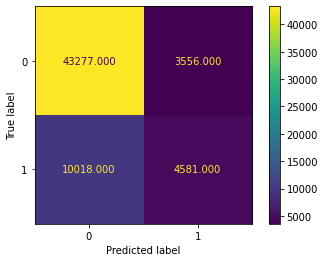

In [ ]:
plot_confusion_matrix(estimator= clf_rforest,X=x_test, y_true=y_test, values_format= '.3f')

In [ ]:
roc_auc_score(y_true=y_test, y_score=y_hat_rf_proba[:,1])

0.7564351520185456

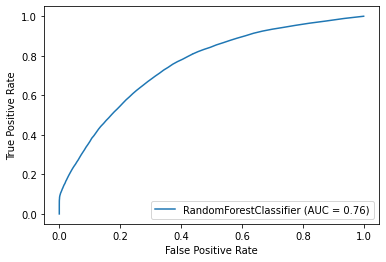

In [ ]:
plot_roc_curve(clf_rforest, X=x_test, y=y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:

# using logistic_regression
clf_logistic = LogisticRegression()
clf_logistic.fit(x_train, y_train)
y_hat_logistic = clf_logistic.predict(x_test)

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
def metrics(Pred, Classifier, X_Test=x_test, labels=y_test):
  # prints different metrics
  accuracy = accuracy_score(y_true=labels, y_pred=Pred)
  roc_auc = roc_auc_score(y_true=labels, y_score=Pred)
  print(f'Accuracy: {accuracy} \n ROC_AUC_Score: {roc_auc}')
  
  
  
  plot_confusion_matrix(estimator= Classifier,X=X_Test, y_true=labels, values_format= '.3f')

  
  plot_roc_curve(Classifier, X=X_Test, y=labels)

  return accuracy, roc_auc_score



Accuracy: 0.7775589269436124 
 ROC_AUC_Score: 0.6171801889192811


(0.7775589269436124, <function sklearn.metrics._ranking.roc_auc_score>)

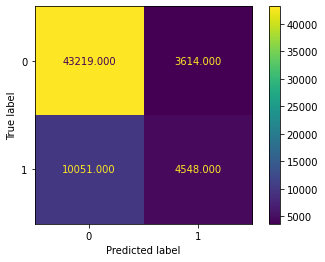

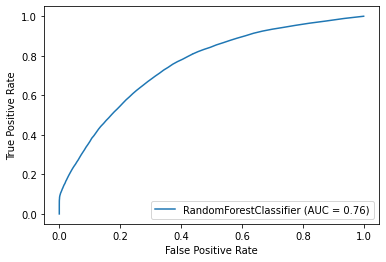

In [ ]:
metrics(y_hat_rforest,clf_rforest)

Accuracy: 0.7177041281416852 
 ROC_AUC_Score: 0.6854151417165041


(0.7177041281416852, <function sklearn.metrics._ranking.roc_auc_score>)

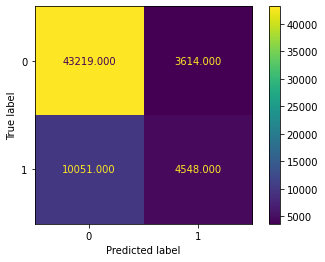

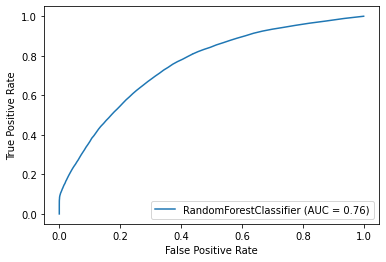

In [ ]:
threshold = 0.3
predicted = (y_hat_rf_proba [:,1] >= threshold).astype('int')
metrics(predicted,clf_rforest)

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf_svc = SVC(kernel='poly',degree=3 ,random_state= 25)
clf_svc.fit(x_test, y_test)
y_hat_svc = clf_svc.predict(x_test)


Accuracy: 0.7623551243651517 
 ROC_AUC_Score: 0.5


(0.7623551243651517, <function sklearn.metrics._ranking.roc_auc_score>)

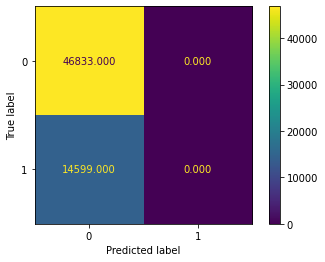

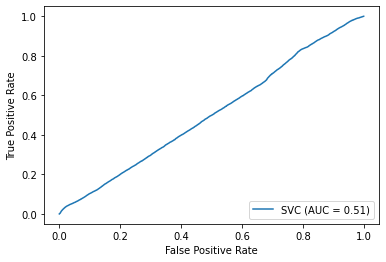

In [ ]:
metrics(y_hat_svc,clf_svc)

In [ ]:

label_name = [1,0]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf_rforest.estimators_[0],
               feature_names = feature_list, 
               class_names=label_name,
               filled = True);

fig.savefig('rf_individualtree.png')